In [21]:

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, fbeta_score, precision_recall_curve,  ConfusionMatrixDisplay
import seaborn as sns
import optuna
import xgboost as xgb
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.calibration import calibration_curve



In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
def precision_recall_curve_with_threshold(targets, probas, threshold = 0.5):
    
    def sort_pair(X, Y):
        rangee = [(x, y) for x, y in sorted(zip(X, Y), key = lambda pair: pair[0])]
        return [pair[0] for pair in rangee], [pair[1] for pair in rangee]
    
    # --- main
    targets, probas = sort_pair(targets, probas)
    precision, recall, thresholds = metrics.precision_recall_curve(targets, probas)
    
    # calculate precision-recall AUC
    auc_val = metrics.auc(recall, precision)
    print('Area Under Curve (AUC) : {:.3f}'.format(auc_val))
    # plot no skill
    if threshold is not None : 
        index = len([y for y in thresholds if y <= threshold]) # thresholds are sorted

        print('Recall with threshold = {}: {:.2f}%'.format(threshold, recall[index]*100))
        print('Precision with threshold = {} : {:.2f}%'.format(threshold, precision[index]*100))

        plt.plot([0, 1], [precision[index], precision[index]], linestyle='--', color = 'grey')
        plt.plot([recall[index], recall[index]], [0, 1], linestyle='--', color = 'grey')
        
        # plot the precision-recall curve for the model
        plt.plot(recall[:index], precision[:index], color = 'navy', marker='.')
        plt.plot(recall[index:], precision[index:], color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve with threshold = {}'.format(threshold))
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')
    else :
        # plot the precision-recall curve for the model
        plt.plot(recall, precision, color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')

    plt.show()
    return

In [4]:
df_processed=pd.read_feather('transformed')
display_all(df_processed.T)

0      1      2       \
GeneralHealth                                           3      4      3   
PhysicalHealthDays                                    0.0    0.0    2.0   
MentalHealthDays                                      0.0    0.0    3.0   
LastCheckupTime                                         0     -1      0   
SleepHours                                            8.0    6.0    5.0   
RemovedTeeth                                           -1     -1     -1   
HadHeartAttack                                        0.0    0.0    0.0   
HadDiabetes                                             3      0      0   
SmokerStatus                                            0      0      0   
ECigaretteUsage                                         1      0      0   
HeightInMeters                                        1.7    1.6   1.57   
WeightInKilograms                                   80.74  68.04   63.5   
BMI                                                 27.44  26.57  25.61   
TetanusLast10Tdap                                       2      0     -1   
CovidPos                                                0      0      2   
State_Alaska                                        False  False  False   
State_Arizona                                       False  False  False   
State_Arkansas                                      False  False  False   
State_California                                    False  False  False   
State_Colorado                                      False  False  False   
State_Connecticut                                   False  False  False   
State_Delaware                                      False  False  False   
State_District of Columbia                          False  False  False   
State_Florida                                       False  False  False   
State_Georgia                                       False  False  False   
State_Guam                                          False  False  False   
State_Hawaii                                        False  False  False   
State_Idaho                                         False  False  False   
State_Illinois                                      False  False  False   
State_Indiana                                       False  False  False   
State_Iowa                                          False  False  False   
State_Kansas                                        False  False  False   
State_Kentucky                                      False  False  False   
State_Louisiana                                     False  False  False   
State_Maine                                         False  False  False   
State_Maryland                                      False  False  False   
State_Massachusetts                                 False  False  False   
State_Michigan                                      False  False  False   
State_Minnesota                                     False  False  False   
State_Mississippi                                   False  False  False   
State_Missouri                                      False  False  False   
State_Montana                                       False  False  False   
State_Nebraska                                      False  False  False   
State_Nevada                                        False  False  False   
State_New Hampshire                                 False  False  False   
State_New Jersey                                    False  False  False   
State_New Mexico                                    False  False  False   
State_New York                                      False  False  False   
State_North Carolina                                False  False  False   
State_North Dakota                                  False  False  False   
State_Ohio                                          False  False  False   
State_Oklahoma                                      False  False  False   
State_Oregon                                        False  False  False   
S

### Split the dataset

In [5]:
target_col = 'HadHeartAttack'
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"train set size: {X_train.shape}")
print(f"validation set size: {X_valid.shape}")

train set size: (356105, 130)
validation set size: (89027, 130)


# Model Training

### 1. RandomForest Model

In [ ]:
def objective_rf(trial):
    pos_weight = trial.suggest_float('pos_weight', 1.0, 20.0, step=0.5)
    class_weight_dict = {0: 1, 1: pos_weight}
    n_estimators = trial.suggest_int('n_estimators', 100, 800, step=50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.1)
    max_samples = trial.suggest_float('max_samples', 0.5, 0.99)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        bootstrap=True,
        max_samples=max_samples,
        max_features=max_features,
        oob_score=True,        
        class_weight=class_weight_dict, 
        n_jobs=-1,              
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = average_precision_score(y_valid, y_pred_proba)
    return score

study_rf = optuna.create_study(study_name='RFstudy', 
                               load_if_exists=True, 
                                storage = "sqlite:///opt.db",
                                direction='maximize')
study_rf.optimize(objective_rf, n_trials=50) 
print("Best parameter:", study_rf.best_params)
print("Best model:", study_rf.best_value)

[I 2025-12-07 09:59:26,636] A new study created in RDB with name: RFstudyf
[I 2025-12-07 09:59:43,572] Trial 0 finished with value: 0.859941394463373 and parameters: {'n_estimators': 450, 'criterion': 'gini', 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.047989768442207294, 'max_samples': 0.515582902069644, 'max_features': 'log2'}. Best is trial 0 with value: 0.859941394463373.
[I 2025-12-07 10:00:05,594] Trial 1 finished with value: 0.8562021480819195 and parameters: {'n_estimators': 650, 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 11, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.07839041132947755, 'max_samples': 0.6670423443124793, 'max_features': 'log2'}. Best is trial 0 with value: 0.859941394463373.
[I 2025-12-07 10:00:37,369] Trial 2 finished with value: 0.8802764485273783 and parameters: {'n_estimators': 500, 'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 16, 'min_weight_fra

KeyboardInterrupt: 

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators = 400, 
    class_weight = 'balanced', 
    criterion = 'gini',  
    max_depth = 19, 
    min_samples_split = 11, 
    min_samples_leaf = 9, 
    min_weight_fraction_leaf = 0.0004142722852582705, 
    bootstrap = True, 
    oob_score = True, 
    max_samples = 0.5280246944505804,
    random_state = 42,
)
rf_model.fit(X_train, y_train)
print("Score on training set : ", rf_model.score(X_train, y_train))
print("Score on validation set : ",rf_model.score(X_valid, y_valid))
print("Out-of-bag score: ", rf_model.oob_score_)

Score on training set :  0.8108226506227096
Score on validation set :  0.8074179743223966
Out-of-bag score:  0.8162395578821435


In [20]:
y_prob_rf = rf_model.predict_proba(X_valid)[:, 1]
y_pred_default = rf_model.predict(X_valid)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob_rf):.4f}")
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_default))

ROC-AUC Score: 0.8870

Default threshold (0.5) classification:
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     84005
         1.0       0.20      0.80      0.32      5022

    accuracy                           0.81     89027
   macro avg       0.59      0.80      0.60     89027
weighted avg       0.94      0.81      0.86     89027



Area Under Curve (AUC) : 0.406
Recall with threshold = 0.5: 77.12%
Precision with threshold = 0.5 : 21.65%


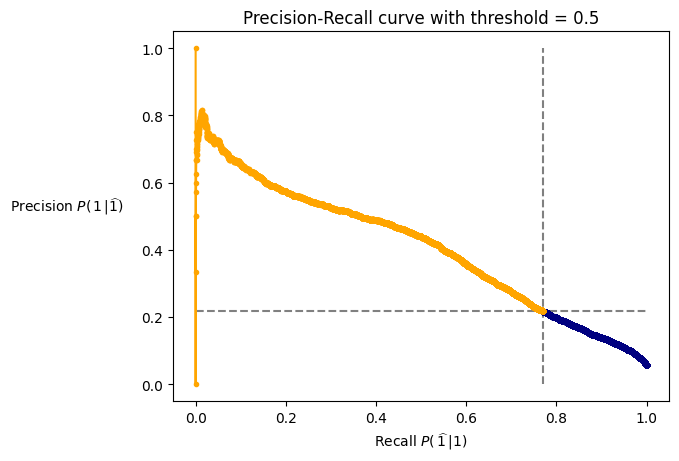

In [11]:
precision_recall_curve_with_threshold(y_valid,y_prob_rf,threshold=0.5)

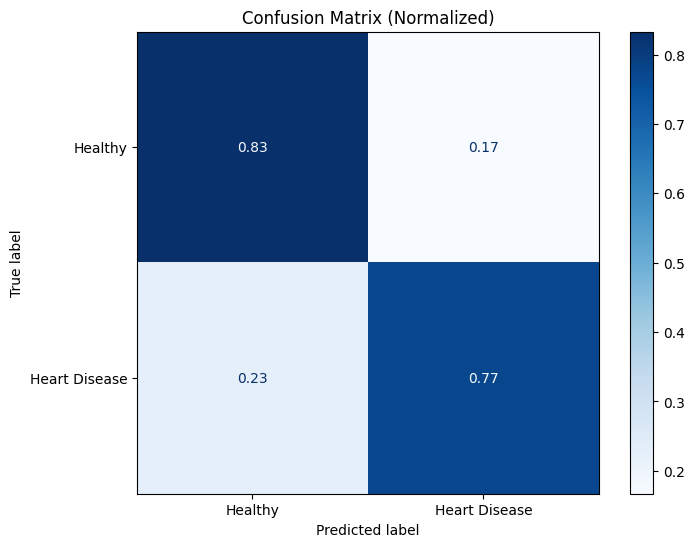

In [12]:

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_valid, 
    y_pred_default,
    display_labels=['Healthy', 'Heart Disease'],
    cmap='Blues',
    normalize='true', 
    ax=ax
)
plt.title("Confusion Matrix (Normalized)")
plt.show()




In [13]:
thresholds = [0.1,0.2,0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_pred_adjusted = (y_prob_rf >= threshold).astype(int)
    rec = metrics.recall_score(y_valid, y_pred_adjusted)
    prc = metrics.precision_score(y_valid, y_pred_adjusted)
    f1 =metrics.f1_score(y_valid, y_pred_adjusted)
    print(f"Threshold {threshold}: Recall={rec:.3f}, Precision={prc:.3f}", f", F1-Score={f1:.3f}")

Threshold 0.1: Recall=0.993, Precision=0.069 , F1-Score=0.129
Threshold 0.2: Recall=0.972, Precision=0.092 , F1-Score=0.168
Threshold 0.3: Recall=0.931, Precision=0.121 , F1-Score=0.215
Threshold 0.4: Recall=0.863, Precision=0.159 , F1-Score=0.269
Threshold 0.5: Recall=0.771, Precision=0.217 , F1-Score=0.338
Threshold 0.6: Recall=0.663, Precision=0.304 , F1-Score=0.417


In [ ]:
best_th = 0.5
best_score = 0

for th in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (y_prob_rf >= th).astype(int)
    score = fbeta_score(y_valid, y_pred_temp, beta=2) 
    if score > best_score:
        best_score = score
        best_th = th
print(f"Best threshold: {best_th:.2f} (F2-Score: {best_score:.4f})")
print(classification_report(y_valid, (y_prob_rf >= best_th).astype(int)))

Best threshold: 0.60 (F2-Score: 0.5362)
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     84005
         1.0       0.30      0.66      0.42      5022

    accuracy                           0.90     89027
   macro avg       0.64      0.79      0.68     89027
weighted avg       0.94      0.90      0.91     89027



In [ ]:
y_valid_proba = rf_model.predict_proba(X_valid)[:, 1]


prob_true, prob_pred = calibration_curve(y_valid, y_valid_proba, n_bins=10)

# --- 3. 开始画图 ---
plt.figure(figsize=(8, 6))

# 画一条灰色的对角虚线（这是“完美标准”，线上的点代表预测 80% 就是真 80%）
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')

# 画你的随机森林模型的表现（蓝色线）
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest (Yours)', color='blue')

# 设置标签和标题
plt.xlabel('Mean Predicted Probability (模型预测的概率)')
plt.ylabel('Fraction of Positives (实际患病的比例)')
plt.title('Calibration Curve - Is my model confident or lying?')
plt.legend()
plt.grid(True, alpha=0.3)

# 显示图片
plt.show()

In [ ]:
calibrated_classifier = CalibratedClassifierCV(
    estimator = rf_model,
    method = 'sigmoid',
    ensemble = True,
    cv = 3,
    n_jobs = -1,
)

In [14]:
calibrated_classifier.fit(X_train, y_train)
print(calibrated_classifier.score(X_valid, y_valid))

0.9461397516230461


In [15]:
y_predict_valid2 = calibrated_classifier.predict(X_valid)

acc2 = metrics.accuracy_score(y_valid, y_predict_valid2)
rec2 = metrics.recall_score(y_valid, y_predict_valid2)
prc2 = metrics.precision_score(y_valid, y_predict_valid2)
f1_2 = metrics.f1_score(y_valid, y_predict_valid2)

print('Accuracy : {:.2f}%'.format(acc2*100))
print('Recall : {:.2f}%'.format(rec2*100))
print('Precision : {:.2f}%'.format(prc2*100))

Accuracy : 94.61%
Recall : 21.43%
Precision : 56.87%


In [16]:
y_pred_proba2 =calibrated_classifier.predict_proba(X_valid)[:, 1]
thresholds2 = [0.1,0.2,0.3, 0.4, 0.5, 0.6]
for threshold in thresholds2:
    y_pred_adjusted2 = (y_pred_proba2 >= threshold).astype(int)
    rec3 = metrics.recall_score(y_valid, y_pred_adjusted2)
    prc3 = metrics.precision_score(y_valid, y_pred_adjusted2)
    
    print(f"Threshold {threshold}: Recall={rec3:.3f}, Precision={prc3:.3f}")

Threshold 0.1: Recall=0.697, Precision=0.278
Threshold 0.2: Recall=0.554, Precision=0.402
Threshold 0.3: Recall=0.462, Precision=0.466
Threshold 0.4: Recall=0.353, Precision=0.507
Threshold 0.5: Recall=0.214, Precision=0.569
Threshold 0.6: Recall=0.051, Precision=0.708


## Catboost


In [17]:
CatBoost=CatBoostClassifier(
    iterations=1500,
    depth=6,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    l2_leaf_reg=3,
    boosting_type='Ordered',
    subsample=0.8,
    early_stopping_rounds=200,
    verbose=100,
    eval_metric='Recall',
    loss_function='Logloss',
    random_seed=42,
    use_best_model=True)
CatBoost.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[])

0:	learn: 0.7573932	test: 0.7570689	best: 0.7570689 (0)	total: 131ms	remaining: 3m 16s
100:	learn: 0.7823857	test: 0.7729988	best: 0.7737953 (92)	total: 6.17s	remaining: 1m 25s
200:	learn: 0.7885592	test: 0.7773795	best: 0.7775787 (176)	total: 12.1s	remaining: 1m 18s
300:	learn: 0.7897043	test: 0.7775787	best: 0.7781760 (248)	total: 17.5s	remaining: 1m 9s
400:	learn: 0.7897043	test: 0.7781760	best: 0.7783751 (338)	total: 21.9s	remaining: 1m
500:	learn: 0.7894553	test: 0.7777778	best: 0.7783751 (338)	total: 26.9s	remaining: 53.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7783751493
bestIteration = 338

Shrink model to first 339 iterations.


In [18]:
y_prob_catboost = CatBoost.predict_proba(X_valid)[:, 1]

y_pred_catboost = CatBoost.predict(X_valid)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob):.4f}")
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_catboost))

ROC-AUC Score: 0.8865

Default threshold (0.5) classification:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     83392
           1       0.22      0.78      0.34      5022

    accuracy                           0.83     88414
   macro avg       0.60      0.80      0.62     88414
weighted avg       0.94      0.83      0.87     88414



In [ ]:
def objective_catboost_ohe(trial):
    param = {
        
        'objective': 'Logloss',
        'eval_metric': 'PRAUC',
        'random_seed': 42,
        'verbose': 0,
        'allow_writing_files': False,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 5),
    }
    model = CatBoostClassifier(**param)
    model.fit(
        X_train, y_train,     
        eval_set=(X_valid, y_valid),      
        early_stopping_rounds=50,
        verbose=False
    )
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = average_precision_score(y_valid, y_pred_proba)
    
    return score



In [31]:
study_cat = optuna.create_study(study_name="cat_opt_heart_attack", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction='maximize')

study_cat.optimize(objective_catboost_ohe, n_trials=50)

[I 2025-11-28 17:03:50,794] A new study created in RDB with name: cat_opt_heart_attack
[I 2025-11-28 17:03:54,859] Trial 0 finished with value: 0.4233370009848511 and parameters: {'n_estimators': 699, 'max_depth': 9, 'learning_rate': 0.16722080842945974, 'l2_leaf_reg': 1.2896049956863458, 'subsample': 0.9647519393257147, 'scale_pos_weight': 4.365946321536863}. Best is trial 0 with value: 0.4233370009848511.
[I 2025-11-28 17:03:59,020] Trial 1 finished with value: 0.4221261747520293 and parameters: {'n_estimators': 1340, 'max_depth': 8, 'learning_rate': 0.19044062243245652, 'l2_leaf_reg': 0.16204752241489545, 'subsample': 0.9517790440190721, 'scale_pos_weight': 1.0502976453843584}. Best is trial 0 with value: 0.4233370009848511.
[I 2025-11-28 17:04:08,531] Trial 2 finished with value: 0.4303341991211199 and parameters: {'n_estimators': 492, 'max_depth': 4, 'learning_rate': 0.09228354119130291, 'l2_leaf_reg': 2.6379021838140533, 'subsample': 0.7549387080905762, 'scale_pos_weight': 3.1002

In [19]:
best_score_catboost=0
for th in np.arange(0.1, 0.9, 0.05):
    y_pred_temp_catboost = (y_prob_catboost >= th).astype(int)
    score_catboost = fbeta_score(y_valid, y_pred_temp_catboost, beta=2) 
    if score_catboost > best_score_catboost:
        best_score_catboost = score_catboost
        best_th = th

print(f"Best threshold: {best_th:.2f} (F2-Score: {best_score_catboost:.4f})")
print(classification_report(y_valid, (y_prob_catboost >= best_th).astype(int)))

Best threshold: 0.70 (F2-Score: 0.5404)
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     83392
           1       0.35      0.63      0.45      5022

    accuracy                           0.91     88414
   macro avg       0.66      0.78      0.70     88414
weighted avg       0.94      0.91      0.92     88414



## XGBoost Model 

In [20]:
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
xgboost = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  
    eval_metric='aucpr',                
    n_jobs=-1,
    random_state=42,
    tree_method='hist'                  
)

xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

In [21]:
y_pred_proba_xgboost = xgboost.predict_proba(X_valid)[:, 1]

roc_xgboost = roc_auc_score(y_valid, y_pred_proba_xgboost)
print(f"ROC-AUC Score: {roc_xgboost:.4f}")

precision_xg, recall_xg, thresholds_xg = precision_recall_curve(y_valid, y_pred_proba_xgboost)
pr_auc_xg = metrics.auc(recall_xg, precision_xg)
print(f"PR-AUC Score: {pr_auc_xg:.4f}")

f2_scores_xgboost = [fbeta_score(y_valid, (y_pred_proba_xgboost >= t).astype(int), beta=2) for t in thresholds]
best_idx_xg = np.argmax(f2_scores_xgboost)
best_threshold_xg = thresholds[best_idx_xg]
best_f2_xg = f2_scores_xgboost[best_idx_xg]

print(f"\nBest threshold: {best_threshold_xg:.3f}")
print(f" F2-Score: {best_f2_xg:.4f}")

y_pred_optimal = (y_pred_proba_xgboost >= best_threshold_xg).astype(int)
print(classification_report(y_valid, y_pred_optimal))

ROC-AUC Score: 0.8899
PR-AUC Score: 0.4248

Best threshold: 0.600
 F2-Score: 0.5359
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     83392
           1       0.28      0.70      0.40      5022

    accuracy                           0.88     88414
   macro avg       0.63      0.79      0.67     88414
weighted avg       0.94      0.88      0.90     88414



In [ ]:


def objective(trial):
   
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',  
        'tree_method': 'hist',   
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10) 
    }
    
  
    
    model = xgb.XGBClassifier(**param)
    
    model.fit(
        X_train, y_train, 
        eval_set=[(X_valid, y_valid)], 
             
        verbose=False)
    
   
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = average_precision_score(y_valid, y_pred_proba)
    
    return score

In [27]:
study = optuna.create_study(study_name="xgb_opt_heart_attack", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction='maximize')

study.optimize(objective, n_trials=50)

[I 2025-11-28 16:48:30,909] Using an existing study with name 'xgb_opt_heart_attack' instead of creating a new one.
[I 2025-11-28 16:48:40,254] Trial 1 finished with value: 0.4260418261129608 and parameters: {'n_estimators': 306, 'max_depth': 9, 'learning_rate': 0.016474376635258928, 'subsample': 0.953090837716706, 'colsample_bytree': 0.8828055472896199, 'gamma': 1.5026517647835176, 'min_child_weight': 6, 'scale_pos_weight': 7.673529369478981}. Best is trial 1 with value: 0.4260418261129608.
[I 2025-11-28 16:48:51,759] Trial 2 finished with value: 0.4275636897625179 and parameters: {'n_estimators': 505, 'max_depth': 6, 'learning_rate': 0.04712440008531449, 'subsample': 0.673899387357362, 'colsample_bytree': 0.6236343246726777, 'gamma': 4.765275176579431, 'min_child_weight': 5, 'scale_pos_weight': 4.513769124524497}. Best is trial 2 with value: 0.4275636897625179.
[I 2025-11-28 16:49:05,707] Trial 3 finished with value: 0.3978697998201343 and parameters: {'n_estimators': 629, 'max_depth

In [28]:
print("Best PR-AUC :", study.best_value)
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Best PR-AUC : 0.43155101727413353
  n_estimators: 538
  max_depth: 7
  learning_rate: 0.011487012128649322
  subsample: 0.7006077032886026
  colsample_bytree: 0.9410623730990839
  gamma: 2.0360366937851744
  min_child_weight: 8
  scale_pos_weight: 4.084372168445866
